In [21]:
%cd /Users/masha/Documents/visual-reasoning


/Users/masha/Documents/visual-reasoning


In [22]:
import os
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
MODEL_PATH = 'models/rotator_l2_100e_10k.pth'
print('DEVICE:', DEVICE)

DEVICE: mps


In [23]:
CHIRAL_SHAPES = {
    'L': [(0,-1),(0,0),(0,1),(1,1)],
    'Z': [(0,0),(-1,0),(0,1),(1,1)],
    'S': [(0,0),(1,0),(0,1),(-1,1)],
}

def draw_shape_np(name, size=64):
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block = size // 8
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + dx * block - block // 2
        y = center + dy * block - block // 2
        cv2.rectangle(img, (x, y), (x + block, y + block), 255, -1)
    return img

def norm_tensor(x):
    return (torch.tensor(x).float().unsqueeze(0) / 255.0 - 0.5) / 0.5

class PairDataset(Dataset):
    def __init__(self, n=1000):
        self.n = n
    def __len__(self): return self.n
    def __getitem__(self, idx):
        key = random.choice(list(CHIRAL_SHAPES.keys()))
        base_np = draw_shape_np(key, 64)
        angle = random.randint(0, 359)
        M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)
        is_same = (random.random() > 0.5)
        if is_same:
            target_np = cv2.warpAffine(base_np, M, (64, 64))
            label = 1.0
        else:
            target_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (64, 64))
            label = 0.0
        return norm_tensor(base_np), norm_tensor(target_np), torch.tensor([label]).float()

train_loader = DataLoader(PairDataset(2000), batch_size=16, shuffle=True)
test_loader = DataLoader(PairDataset(400), batch_size=16, shuffle=False)


In [24]:
# --- Rotator (same as exhaustive search) ---
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class FastRotator(nn.Module):
    def __init__(self, backbone_dim=384, flow_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.angle_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(1, flow_dim)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim, flow_dim*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim*2, flow_dim*4))

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(flow_dim*6, flow_dim*2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(flow_dim*3, flow_dim)

        self.outc = nn.Conv2d(flow_dim, 1, kernel_size=1)

    def forward(self, x_t, t, dino_emb, target_angle_deg):
        t_emb = self.time_mlp(t)
        d_emb = self.cond_proj(dino_emb)
        a_emb = self.angle_mlp(target_angle_deg / 360.0)
        global_cond = (t_emb + d_emb + a_emb).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = x3 + global_cond

        x = self.conv1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.conv2(torch.cat([self.up2(x), x1], dim=1))
        return self.outc(x)

rotator = FastRotator().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(MODEL_PATH)
rotator.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
rotator.eval()

@torch.no_grad()
def apply_rotation(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    if torch.is_tensor(angle_deg):
        target_ang = angle_deg.to(DEVICE)
        if target_ang.ndim == 1:
            target_ang = target_ang.view(-1, 1)
    else:
        target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    for i in range(steps):
        t = torch.full((B, 1), i/steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
    return curr


In [25]:
# --- Reasoning model: encoder + controller + rotator-in-the-loop ---
class TinyEncoder(nn.Module):
    def __init__(self, in_ch=1, dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, dim, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(dim, dim, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(dim, dim, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.net(x).squeeze(-1).squeeze(-1)

class Controller(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*2, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, h_state, h_target):
        return self.mlp(torch.cat([h_state, h_target], dim=-1))

class Reasoner(nn.Module):
    def __init__(self, steps=8, enc_dim=64):
        super().__init__()
        self.steps = steps
        self.encoder = TinyEncoder(dim=enc_dim)
        self.controller = Controller(dim=enc_dim)
        self.to_rotator = nn.Linear(enc_dim, 384)
        self.head = nn.Sequential(nn.Linear(enc_dim, 64), nn.ReLU(), nn.Linear(64, 1))

    def forward(self, img_a, img_b):
        # Encode target once
        h_target = self.encoder(img_b)

        # Initialize state
        curr = img_a
        h_state = self.encoder(curr)

        # Unroll rotation reasoning
        for _ in range(self.steps):
            delta = self.controller(h_state, h_target)
            # clamp to keep small steps (degrees)
            delta = torch.clamp(delta, -30.0, 30.0)
            rot_emb = self.to_rotator(h_state).detach()
            curr = apply_rotation(rotator, curr, rot_emb, delta, steps=10)
            h_state = self.encoder(curr)

        # Decision head
        logits = self.head(h_state)
        return logits

reasoner = Reasoner(steps=8).to(DEVICE)
opt = torch.optim.Adam(reasoner.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()


In [26]:
EPOCHS = 5
for epoch in range(EPOCHS):
    reasoner.train()
    total = 0.0
    for img_a, img_b, label in train_loader:
        img_a = img_a.to(DEVICE)
        img_b = img_b.to(DEVICE)
        label = label.to(DEVICE)

        logits = reasoner(img_a, img_b)
        loss = loss_fn(logits, label)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()
    print(f'Epoch {epoch+1}: loss={total/len(train_loader):.4f}')

Epoch 1: loss=0.6939
Epoch 2: loss=0.6930
Epoch 3: loss=0.6934
Epoch 4: loss=0.6934
Epoch 5: loss=0.6933


In [27]:
# --- Eval ---
reasoner.eval()
y_true = []
y_scores = []
with torch.no_grad():
    for img_a, img_b, label in test_loader:
        img_a = img_a.to(DEVICE)
        img_b = img_b.to(DEVICE)
        label = label.to(DEVICE)
        logits = reasoner(img_a, img_b)
        probs = torch.sigmoid(logits)
        y_true.extend(label.cpu().numpy().flatten().tolist())
        y_scores.extend(probs.cpu().numpy().flatten().tolist())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = (y_scores >= 0.5).astype(float)
acc = (y_pred == y_true).mean()
auc = metrics.roc_auc_score(y_true, y_scores)
print(f'Accuracy: {acc*100:.2f}%')
print(f'AUC: {auc:.4f}')


Accuracy: 48.00%
AUC: 0.4437


/var/folders/27/76q8rfwn799g95yl3x7jwbnh0000gn/T/ipykernel_4476/4070926791.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = float(deltas[i-1])


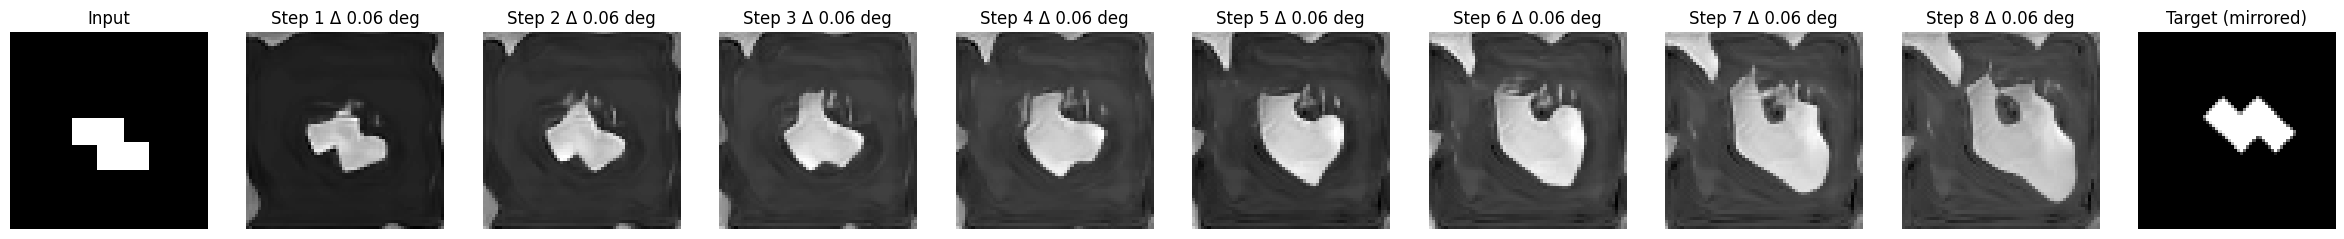

In [28]:
# --- Visualize reasoning steps (rotator-in-the-loop) ---
# Shows the intermediate rotated states and chosen deltas

@torch.no_grad()
def run_reasoning_steps(reasoner, img_a, img_b, steps=8, inner_steps=10):
    reasoner.eval()
    h_target = reasoner.encoder(img_b)
    curr = img_a.clone()
    h_state = reasoner.encoder(curr)

    frames = [curr.clone()]
    deltas = []

    for _ in range(steps):
        delta = reasoner.controller(h_state, h_target)
        delta = torch.clamp(delta, -30.0, 30.0)
        rot_emb = reasoner.to_rotator(h_state).detach()
        curr = apply_rotation(rotator, curr, rot_emb, delta, steps=inner_steps)
        h_state = reasoner.encoder(curr)
        frames.append(curr.clone())
        deltas.append(delta.detach().cpu().numpy())

    return frames, deltas

# Sample a pair
key = random.choice(list(CHIRAL_SHAPES.keys()))
base_np = draw_shape_np(key, 64)
base = norm_tensor(base_np).unsqueeze(0).to(DEVICE)

angle = random.randint(0, 359)
M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)

is_same = (random.random() > 0.5)
if is_same:
    target_np = cv2.warpAffine(base_np, M, (64, 64))
    label = 'same'
else:
    target_np = cv2.warpAffine(cv2.flip(base_np, 1), M, (64, 64))
    label = 'mirrored'

target = norm_tensor(target_np).unsqueeze(0).to(DEVICE)

frames, deltas = run_reasoning_steps(reasoner, base, target, steps=8, inner_steps=10)

cols = len(frames) + 1
fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3))

axes[0].imshow(base[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")
axes[0].axis('off')

for i in range(1, len(frames)):
    axes[i].imshow(frames[i][0,0].cpu(), cmap='gray')
    d = float(deltas[i-1])
    axes[i].set_title(f"Step {i} Δ {d:.2f} deg")
    axes[i].axis('off')

axes[-1].imshow(target[0,0].cpu(), cmap='gray')
axes[-1].set_title(f"Target ({label})")
axes[-1].axis('off')

plt.show()